# Stock Price Forecasting 



### Problem statement:
Forecasting how a particular equity or the index itself will perform the next day is an elusive problem that investors face on a daily basis that normally involves the study of several factors that could affect a particular company within a sector and the market as a whole. <br>
Can we use machine learning to forecast the price of a given equity based solely on its historical price? <br>
There are many factors that affect the equity's price valuation which include, and not limited to, irrational/rational human behavior, company news, quarterly/yearly revenue reports, analyst ratings and meeting analyst expectations to name a few. All these aspects combined, make share prices volatile and challenging to predict with a high degree of accuracy.
 Broadly, stock market analysis falls into two parts – Fundamental Analysis and Technical Analysis.

- Fundamental Analysis involves analyzing the company’s future profitability on the basis of its current business environment and financial performance.
- Technical Analysis, on the other hand, includes reading the charts and using statistical figures to identify the trends in the stock market.

This notebook will focus on the technical analysis of the equity's price and will explore a few machine learning models in an attempt to predict future closing price of an equity and provide the best prediction model as well as price action recommendations using technical indicators. 


In [105]:
import os
import pandas as pd
import numpy as np
import pip
# visualization 
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style

# store serialized object locally
import pickle 

import datetime as dt
from datetime import timedelta 
from datetime import date

# import plotly for candlestick charts
!pip install plotly --quiet 
import plotly
from plotly import graph_objects as go

# stock data api
# from iexfinance.stocks import Stock
# from iexfinance.stocks import get_historical_data
import quandl as ql
import yfinance as yf

# find optimal ARIMA parameters
import pmdarima.arima as pmd
from pmdarima.arima import auto_arima

# Stats tools for performing stationarity tests and visualization of time series
import statsmodels 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

import sklearn as sk
# from sklearn.model_selection import GridSearchCV
# model evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings 


In [106]:
print('matplotlib ver: %s'%matplotlib.__version__)
print('pandas version: %s'%pd.__version__)
print('numpy version: %s'%np.__version__)
print('scikit learn version: %s' %sk.__version__)
print('plotly version: %s' % plotly.__version__)
print('statsmodels ver: %s'%statsmodels.__version__)

matplotlib ver: 3.2.2
pandas version: 1.0.5
numpy version: 1.19.5
scikit learn version: 0.23.1
plotly version: 4.14.3
statsmodels ver: 0.11.1


In [107]:
style.use('ggplot')
# quandl api key activation
ql.ApiConfig.api_key = open("ql_api_token.txt").read()


### Extracting and loading the data 
Historical end-of-day (EOD) price data will be extracted via the yahoo finance(yfinance) api and quandl. 
In order to send requests to the Quandl server, you'll need to create an account with them and obtain an api key to verify the user. There were some limitations with this data source as they only kept historical data until Dec 2017. You would need to pay in order to retrieve up-to-date price data. <br>
The rest of the data was acquired through yfinance api. In future, the price data will be sourced from yfinance and storing it locally in pickle format.

In [108]:
# Start: 1st trading day in 2014 
start = dt.datetime(2014,1,2)
# latest close date 
end = date.today()
# Using quandl api to retrieve historical data on ticker MSFT (Microsoft)
eod_msft_data = ql.get('EOD/MSFT', start_date=start, end_date=end)
# eod_msft_data.head()
eod_msft_data.tail()
# Free EOD data is limited to end of 2017

,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume
Date,,,,,,,,,,,,
2017-12-21,86.05,86.1000,85.400,85.50,17990745.0,0.0,1.0,82.563848,82.611822,81.940182,82.036130,17990745.0
2017-12-22,85.40,85.6300,84.920,85.51,14145841.0,0.0,1.0,81.940182,82.160864,81.479628,82.045725,14145841.0
2017-12-26,85.31,85.5346,85.030,85.40,9891237.0,0.0,1.0,81.853828,82.069328,81.585171,81.940182,9891237.0
2017-12-27,85.65,85.9800,85.215,85.71,14678025.0,0.0,1.0,82.180053,82.496684,81.762676,82.237622,14678025.0
2017-12-28,85.90,85.9300,85.550,85.72,10594344.0,0.0,1.0,82.419925,82.448710,82.084105,82.247217,10594344.0


In [109]:
# Check for any null values in dataset 
eod_msft_data.isnull().values.any() 

False

In [110]:
# trim down dataframe to necessary columns
adj_close_msft_2017 = eod_msft_data[['Volume','Adj_Close']] 
adj_close_msft_2017.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1006 entries, 2014-01-02 to 2017-12-28
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Volume     1006 non-null   float64
 1   Adj_Close  1006 non-null   float64
dtypes: float64(2)
memory usage: 23.6 KB


In [111]:
# Get remaining data from Yahoo Finance
ticker = 'MSFT'
# if os.path.exists(ticker+'.pickle'):
#     with open(ticker+'.pickle', 'rb') as handle:
#     file_ = pickle.load(handle)
#     print(file_)
# else:
#     msft_yf= yf.download(ticker,start='2018-01-02',end='2019-12-28')
#     with open(ticker+'.pickle', 'wb') as handle:
#         pickle.dump(msft_yf, handle)

msft_yf= yf.download(ticker,start='2018-01-02',end='2019-12-28')

[*********************100%***********************]  1 of 1 completed


We're excluding data points from 2020 as the market had entered unchartered territory in February 2020 since the market had never encountered a situation like this before. The market saw a major sell off in March with the S&P500 plunging by ~30% due to mass fear/concern over a highly infectious SARS-like virus that afflicted the whole world's economic output due to the closure of operations worldwide as they battled with keeping the cases down and flattening the curve. Due to the nature of the event, it would be difficult to predict how the world would recover from an economic downturn due to the pandemic.

Source:
- [WHO Declares COVID-19 a Pandemic](https://pubmed.ncbi.nlm.nih.gov/32191675/)<br>
- [WSJ: New York City Faces Challenges as U.S. Epicenter for Coronavirus ](https://www.wsj.com/articles/new-york-city-faces-challenges-as-u-s-epicenter-for-coronavirus-11584983498)

In [112]:
msft_yf.columns = ['Open','High','Low','Close','Adj_Close','Volume']
msft_yf.head()

,Open,High,Low,Close,Adj_Close,Volume
Date,,,,,,
2018-01-02,86.129997,86.309998,85.500000,85.949997,82.194328,22483800
2018-01-03,86.059998,86.510002,85.970001,86.349998,82.576843,26061400
2018-01-04,86.589996,87.660004,86.570000,87.110001,83.303658,21912000
2018-01-05,87.660004,88.410004,87.430000,88.190002,84.336464,23407100
2018-01-08,88.199997,88.580002,87.599998,88.279999,84.422516,22113000


In [113]:
# Check for any null values in dataset 
msft_yf.isnull().values.any() 

False

In [114]:
# Splice dataframe for volume and adjusted close prices
adj_close_msft_2019 = msft_yf[['Adj_Close','Volume']]
adj_close_msft_2019.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 501 entries, 2018-01-02 to 2019-12-27
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj_Close  501 non-null    float64
 1   Volume     501 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 11.7 KB


In [115]:
# concatenate dataframes
adj_close_msft_merged = adj_close_msft_2017.append(adj_close_msft_2019)
adj_close_msft_merged.describe()

,Volume,Adj_Close
count,1.507000e+03,1507.000000
mean,2.984572e+07,70.604946
std,1.448462e+07,33.312663
min,7.425603e+06,30.286770
25%,2.128605e+07,42.228968
50%,2.664930e+07,58.776510
75%,3.408979e+07,97.605789
max,2.025224e+08,156.932251


Training was designated as all adjusted close data prior to 2019. Adjusted close price was used here because this price is adjusted for the dividends and stock splits that it may have occurred over the selected period of time.

In [116]:
# test/train data split
train = adj_close_msft_merged['Adj_Close'][:'2018-12-31']
test = adj_close_msft_merged['Adj_Close']['2019-01-01':]
train.describe()

count    1257.000000
mean       59.256589
std        22.565603
min        30.286770
25%        41.156288
50%        50.999474
75%        71.541842
max       111.988419
Name: Adj_Close, dtype: float64

#### Visualizing price data 

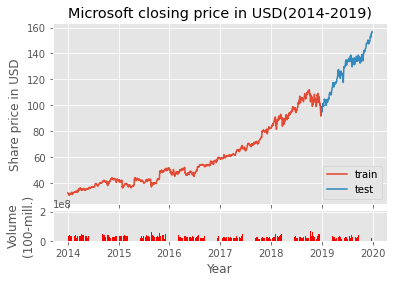

In [117]:
# Plot training and testing data 
ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1,sharex=ax1)
ax1.plot( train, label='train')
ax1.plot( test, label='test')
ax2.bar(x=adj_close_msft_merged.index,height=adj_close_msft_merged['Volume'],color='red')
ax1.set_title('Microsoft closing price in USD(2014-2019)')
ax1.set(ylabel='Share price in USD')
# Number of transactions in a given timestamp 
ax2.set(ylabel='Volume\n(100-mill.)')
ax2.set(xlabel='Year')
leg1 = ax1.legend(loc='lower right')
ax1.add_artist(leg1)
plt.rcParams["figure.figsize"] = (16,10)
plt.show()

In the price chart above, we can see price trend over the past 5 years of the equity and in its subplot the daily trading volume. From this, we can see that the time-series looks noisy, and has a trend to it. 

### Feature Engineering 
#### Technical indicators (features) 
In technical stock analysis, various indicators are used in order to guage the next move in the price of an equity. Some of the most common indicators are: 
- Moving averages (Simple, Exponential): The intersection of moving averages usually hold value in determining the overall trend of the price movement.  eg. Golden Cross, death cross
- Relative strength index (RSI): A popular momentum oscillator. Measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset.
- Trailing and Forward P/E ratio :  If a company is rapidly growing, the forward P/E could be much higher than the trailing P/E. If it sells a piece of its business or undergoes a large scale restructuring, forward earnings could temporarily nosedive. 
<br>
These technical indicators are usually used in conjunction to one another to provide signals for trading opportunities in both long and short term strategies,but is more commonly used in short-term trading strategies.
<br>
(Source: [Investopedia](https://www.investopedia.com/articles/investing/041013/differences-between-forward-pe-and-trailing-pe.asp))

In [118]:
symbol_info = yf.Ticker("msft").info
print("PEG ratio: {} \nTrailing PE ratio: {} \nProjected/Forward PE ratio: {}"
      .format(symbol_info['pegRatio'],symbol_info['trailingPE'],symbol_info['forwardPE']))

PEG ratio: 2.01 
Trailing PE ratio: 33.126194 
Projected/Forward PE ratio: 29.111376


##### Calculating RSI 
The standard is to use 14 periods to calculate the initial RSI value.

In [119]:
def calc_rs(df,price_col='adj close'):
    d_ = df[price_col].diff()
    pos_ = d_.clip(lower=0)
    neg_ = -1*d_.clip(upper=0)
    ema_up = pos_.ewm(com=13, adjust=False).mean()
    ema_down = neg_.ewm(com=13, adjust=False).mean()
    rel_str = ema_up/ema_down
    return rel_str


##### Stochastic oscillator 

In [120]:
def full_stochastic_osc(df, k=14, d=3, smoothing=3):
    ''' Takes dataframe, window frame for %K and %d as well as the smoothing factor,
    and outputs a tuple of K and d.
    Calculates Fast stochastic:
    %K = (Current Close - Lowest Low)/
    (Highest High - Lowest Low) * 100
    %D = 3-day SMA of %K 
    '''
    
    low_min  = df['Low'].rolling( window = k ).min()
    high_max = df['High'].rolling( window = k ).max()
    
    fast_K = 100 * ((df['Close'] - low_min)/(high_max - low_min))
    fast_D = fast_K.rolling(window=d).mean()
    full_K = fast_K.rolling(window = smoothing).mean()
    full_D = full_K.rolling(window = d).mean()
    
    return (full_K, full_D)
    


In [121]:
def slope_indicator(df, periods=5):
    
    slope = np.polyfit(range(len(df)),df,1)[0]
    return slope
# slope_ = full_msft_df['Adj_Close'].rolling(15,min_periods=5).apply(slope_indicator)[4::5]
# plt.plot(slope_)
# plt.show()

In [122]:
# Daily prices including highs and lows with volume for hockeystick graph
full_msft_df = eod_msft_data[['Open','High','Low','Close','Adj_Close','Volume']].append(msft_yf)
# If a stock underwent a split, you'd have to create a new dataset based on the Adjusted Close values.
full_msft_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1507 entries, 2014-01-02 to 2019-12-27
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1507 non-null   float64
 1   High       1507 non-null   float64
 2   Low        1507 non-null   float64
 3   Close      1507 non-null   float64
 4   Adj_Close  1507 non-null   float64
 5   Volume     1507 non-null   float64
dtypes: float64(6)
memory usage: 82.4 KB


In [123]:
# Change in slope over 5 days
full_msft_df['slope-chg-5d'] = slope_indicator(full_msft_df['Adj_Close'])

# Simple moving averages 
full_msft_df['50d-sma'] = full_msft_df['Adj_Close'].rolling(50).mean()
full_msft_df['100d-sma'] = full_msft_df['Adj_Close'].rolling(100).mean()
full_msft_df['200d-sma'] = full_msft_df['Adj_Close'].rolling(200).mean()

# Exponential moving averages
full_msft_df['12d-ema'] = full_msft_df['Adj_Close'].ewm(span=12, min_periods=12).mean()
full_msft_df['26d-ema'] = full_msft_df['Adj_Close'].ewm(span=26, min_periods=26).mean()

# Daily returns
full_msft_df['returns'] = full_msft_df['Adj_Close'].pct_change()
# Technical indicators

# MACD
full_msft_df['macd'] = full_msft_df['12d-ema'] - full_msft_df['26d-ema']
full_msft_df['macd-signal'] = full_msft_df['macd'].ewm(span=9, min_periods=9).mean()

# Buy signal from MACD
full_msft_df['ma-crossover-buy'] = np.where(full_msft_df['50d-sma'] > 
                                            full_msft_df['200d-sma'], 1, 0)
full_msft_df['macd-crossover'] = np.where(full_msft_df['macd'] > 
                                          full_msft_df['macd-signal'], 1, 0)

# Momentum indicators 
full_msft_df['rsi'] = 100 - (100/(1+calc_rs(full_msft_df,price_col='Adj_Close')))
full_msft_df['stoch-%K'] = full_stochastic_osc(full_msft_df, 20, 5, 5)[0]
full_msft_df['stoch-%d'] = full_stochastic_osc(full_msft_df, 20, 5 ,5)[1]

# Change in daily volume
full_msft_df['dvol_pct_chng'] = full_msft_df['Volume'].pct_change()


full_msft_df[200:300]

# To-Do: Create function to automatically generate moving average columns

,Open,High,Low,Close,Adj_Close,Volume,slope-chg-5d,50d-sma,100d-sma,200d-sma,...,26d-ema,returns,macd,macd-signal,ma-crossover-buy,macd-crossover,rsi,stoch-%K,stoch-%d,dvol_pct_chng
Date,,,,,,,,,,,,,,,,,,,,,
2014-10-17,43.20,43.935,42.790,43.63,38.559233,40683346.0,0.072575,40.122427,38.645909,36.102975,...,39.848183,0.020824,-0.572810,-0.241917,1,0,39.259642,14.191339,14.746190,-0.170422
2014-10-20,43.06,44.140,42.810,44.08,38.956934,34530887.0,0.072575,40.142669,38.681151,36.137970,...,39.782164,0.010314,-0.555782,-0.304690,1,0,43.001945,21.311217,15.060764,-0.151228
2014-10-21,44.36,44.975,44.190,44.88,39.663956,36433824.0,0.072575,40.177052,38.718193,36.179878,...,39.773408,0.018149,-0.479707,-0.339693,1,0,49.015880,31.232551,17.328962,0.055108
2014-10-22,45.00,45.070,44.225,44.38,39.222067,33579817.0,0.072575,40.196975,38.752134,36.218364,...,39.732568,-0.011141,-0.449887,-0.361732,1,0,45.765727,36.275764,22.369749,-0.078334
2014-10-23,44.62,45.445,44.530,45.02,39.787685,45451869.0,0.072575,40.218373,38.796122,36.262491,...,39.736651,0.014421,-0.376277,-0.364641,1,0,50.307759,46.127794,29.827733,0.353547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-03-06,43.00,43.110,42.150,42.36,37.942939,36248785.0,0.072575,39.741217,40.726968,39.609406,...,38.974154,-0.017397,-0.198888,-0.193312,1,0,37.966263,55.418786,77.030572,0.562883
2015-03-09,42.19,43.125,42.190,42.85,38.381845,32107957.0,0.072575,39.647026,40.725017,39.624107,...,38.930279,0.011568,-0.215540,-0.197758,1,0,43.620724,43.994296,67.436311,-0.114234
2015-03-10,42.35,42.710,42.030,42.03,37.647350,39159730.0,0.072575,39.543660,40.715014,39.636235,...,38.835247,-0.019137,-0.284722,-0.215151,0,0,37.466067,30.261577,56.142574,0.219627


In [124]:

# Training dataset using candlestick format with rangeslider to zoom into prices 
# in a given time period. 

fig = go.Figure(data=[go.Candlestick(x=full_msft_df.index,
                      open=full_msft_df['Open'],
                      close=full_msft_df['Close'],
                      high=full_msft_df['High'],
                      low=full_msft_df['Low'],
                      increasing_line_color='#3D9970',
                      decreasing_line_color='#FF4136',
                      name='Adjusted closing price'
                     )])
# Add 50 day moving average 
fig.add_trace(
    go.Scatter(x=full_msft_df.index, 
               y=full_msft_df["50d-sma"],
               mode='lines',line=dict(width = 0.75),
               name="SMA-50"
              )
    )
# Add 100 day moving average
fig.add_trace(
    go.Scatter(x=full_msft_df.index, 
               y=full_msft_df["100d-sma"],
               mode='lines',line=dict(width = 0.75),
               name="SMA-100"
              )
    )
# Add 200 day moving average 
fig.add_trace(
    go.Scatter(x=full_msft_df.index, 
               y=full_msft_df["200d-sma"],
               mode='lines',line=dict(width = 0.75),
               name="SMA-200"
              )
    )

fig.update_layout(
    title='MSFT price in the last 3 years prior to 2019 as candlestick chart',
    yaxis_title='Adjusted Close Price/USD')

fig.show()



In [125]:
from plotly.subplots import make_subplots

# Plotting technical indicators 
fig1 = make_subplots(rows=3, cols=1)
fig1.append_trace(
    go.Scatter(x=full_msft_df.index, 
               y=full_msft_df["macd"],
               mode='lines',
               line=dict(width = 0.75),
               name="MACD"),row = 1,col = 1
    )
fig1.append_trace(
    go.Scatter(x=full_msft_df.index, 
               y=full_msft_df["macd-signal"],
               mode='lines',
               line=dict(width = 0.75),
               name="MACD-signal"),row=1,col=1
    )
fig1.append_trace(
    go.Scatter(x=full_msft_df.index, 
               y=full_msft_df["stoch-%K"],
               mode='lines',
               line=dict(width = 0.75),
               name="Full Stochastic %K"),row=2,col=1
    )
fig1.append_trace(
    go.Scatter(x=full_msft_df.index, 
               y=full_msft_df["stoch-%d"],
               mode='lines',
               line=dict(width = 0.75),
               name="Full Stochastic %d"),row=2,col=1
    )
fig1.append_trace(
    go.Scatter(x=full_msft_df.index, 
               y=full_msft_df["rsi"],
               mode='lines',
               line=dict(width = 0.75),
               name="Relative Strength Index"),row=3,col=1
    )

fig1['layout'].update(
    shapes=[{'type': 'line','y0':70,'y1': 70,'x0':str(full_msft_df.index[0]),
             'x1':str(full_msft_df.index[-1]),'xref':'x2','yref':'y2',
             'line': {'color': 'red','width': 0.5}},
            {'type': 'line','y0':30,'y1': 30,'x0':str(full_msft_df.index[0]),
             'x1':str(full_msft_df.index[-1]),'xref':'x2','yref':'y2',
             'line': {'color': 'green','width': 0.5}},
            {'type': 'line','y0':70,'y1': 70,'x0':str(full_msft_df.index[0]),
             'x1':str(full_msft_df.index[-1]),'xref':'x3','yref':'y3',
             'line': {'color': 'red','width': 0.5}},
            {'type': 'line','y0':30,'y1': 30,'x0':str(full_msft_df.index[0]),
             'x1':str(full_msft_df.index[-1]),
             'xref':'x3','yref':'y3',
             'line': {'color': 'green','width': 0.5}}]
)
fig1.update_layout(title=go.layout.Title(text="Momentum indicators"))
fig1.show()

In [126]:
import plotly.io as pio
# save interactive plot as html 
pio.write_html(fig, file='img/candlestick-chart.html', auto_open=False)
pio.write_html(fig1, file='img/indicators.html',auto_open=False)


#### Creating labels for training 

Since we don't have any explicit labels provided for this dataset, we will have to create our own labels that will be derived based on strategies for long term investing eg. SMA crossovers. 

In [127]:
def sma_signal_gen(df):
    slope = np.polyfit(range(len(df)),df,1)[0]
    
    df['sell_signal'] = np.where(df['Adj_Close'] < 0.04 * df['200d-sma'], -1)
    df['buy_signal'] = np.where(df['Adj_Close'] < df['200d-sma'] & slope > 0, 1)
    

### Properties of time series


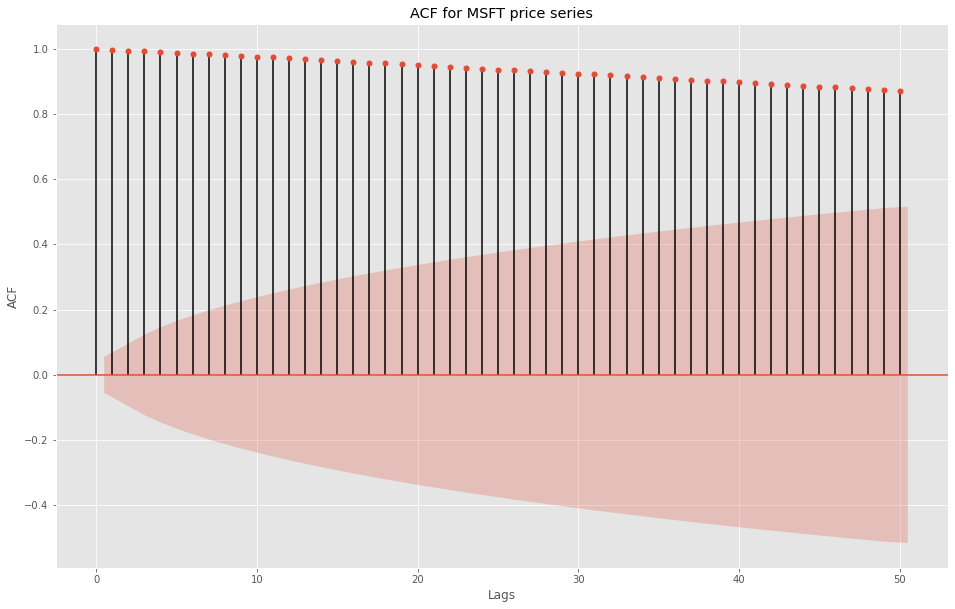

In [128]:
# PLOT ACF 
lag_acf = plot_acf(train,lags=50, title='ACF for MSFT price series')
_ = plt.xlabel('Lags')
_ = plt.ylabel('ACF')

The height of each spike shows the value of the autocorrelation function for the lag.
<br>
The autocorrelation with lag zero always equals 1, because this represents the autocorrelation between each term and itself. Price and price with lag zero are the same variable.
<br>
Each spike that rises above or falls below the dashed lines is considered to be statistically significant.
In this example, the spikes are statistically significant for lags up to 50. This means that the MSFT stock prices are highly correlated with each other. In other words, when the price of MSFT stock rises, it tends to continue rising. When the price of MSFT stock falls, it tends to continue falling.

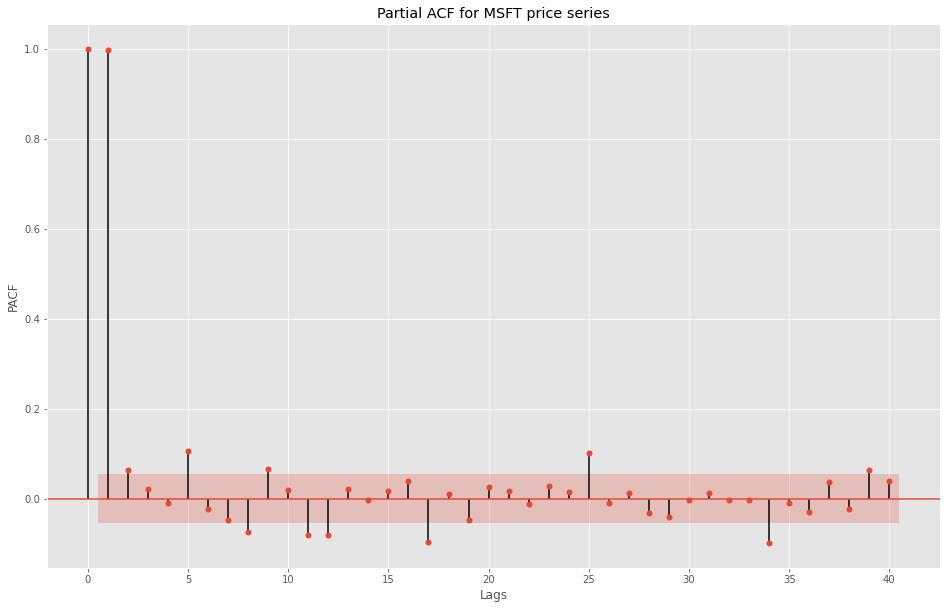

In [129]:
#PLOT PACF
lag_pacf = plot_pacf(train, lags=40, title='Partial ACF for MSFT price series')
_ = plt.xlabel('Lags')
_ = plt.ylabel('PACF')

Looking strictly for what directly affects the series. According to this plot, we can see lags 1,5,17,25,34 have significant correlation prior to differencing.  

#### Summarizing what we've seen thus far 
- The series is currently not stationary and has elements of random walk and a trend to it. 
- Using the ACF and PACF lag values as it stands will not yield an accurate prediction of the time-series.
- The time-series will likely require differencing which will be covered in the subsequent section. We will be trying various methods to transform the series and testing if the series is stationary after transformation.

### Testing for stationarity
<b>H0</b>: The null hypothesis: It is a statement about the population that either is believed to be true or is used to put forth an argument unless it can be shown to be incorrect beyond a reasonable doubt. My null hypothesis is that the series is non-stationary. 

<b>H1</b>: My alternative hypothesis is that the time series is stationary.



In [130]:
# Differencing required?
print("Orders of differencing required: ",pmd.ndiffs(train))

Orders of differencing required:  1


In [131]:
# test timeseries for stationarity using the Augmented Dickey-Fuller test
adf_test_result = adfuller(train)
print('ADF Statistic: %f' % adf_test_result[0])
print('p-value: %f' % adf_test_result[1])
for key, value in adf_test_result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.236500
p-value: 0.974236
	1%: -3.436
	5%: -2.864
	10%: -2.568


Here, the p-value (0.97) is greater than 0.05 so we cannot reject the Null hypothesis and has a unit root. And that the series has some time dependent features as well. 
For time series analysis, we will need to separate trend and seasonality from the time series.

### Decomposing a time series 
Decomposing a time series means separating it into its constituent components, which are usually a trend component and an irregular component, and if it is a seasonal time series, a seasonal component.
To estimate the trend component of a non-seasonal time series that can be described using an additive model, it is common to use a smoothing method, such as calculating the simple moving average of the time series.

#### Differencing the time series
Most time series models assume that each point is independent of one another. Therefore, its important that the statistical properties of a system do not change over time. 

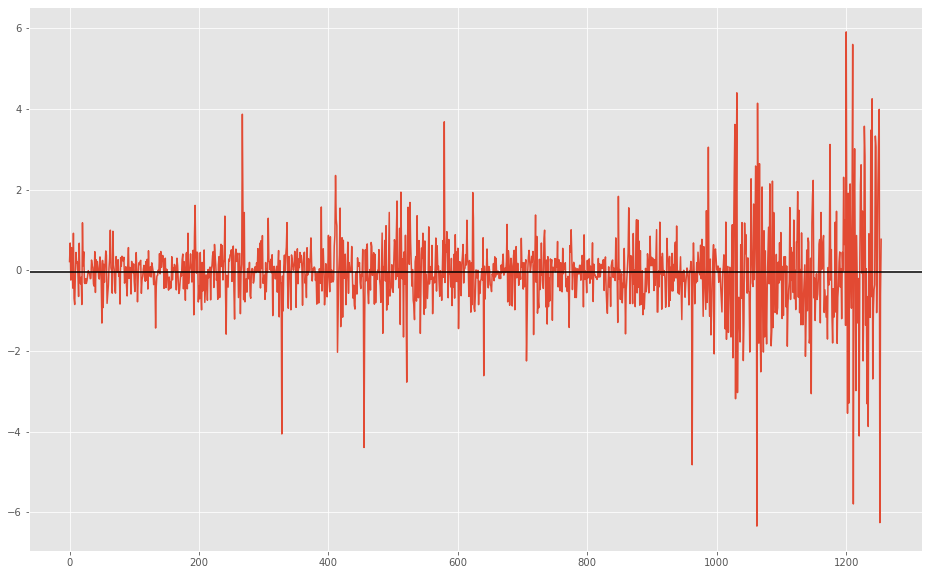

In [132]:
# First order differencing  
train_first_diff = train.values[:-2] - train.values[1:-1]

fig = plt.plot(train_first_diff)
plt.axhline(y=train_first_diff.mean(), color='black')
plt.show()

In [133]:
# Differencing required?
print("Orders of differencing required: ",pmd.ndiffs(train_first_diff))

Orders of differencing required:  0


In [134]:
# Test stationarity 
adf_test_result = adfuller(train_first_diff)
print('ADF Statistic: %f' % adf_test_result[0])
print('p-value: %f' % adf_test_result[1])
for key, value in adf_test_result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.883492
p-value: 0.000000
	1%: -3.436
	5%: -2.864
	10%: -2.568


Based on the outputs from the Augmented Dickey-Fuller (ADF) test, we can see that the p-value is near zero which is less than the critical value we had set for the series (0.05). We can reject the null hypothesis and accept that the series is stationary after differencing the series. <br> 
This differenced series is a potential candidate for our ARMA model. Let's plot out the ACF and PACF to see if there are any lags that are significant in this series.

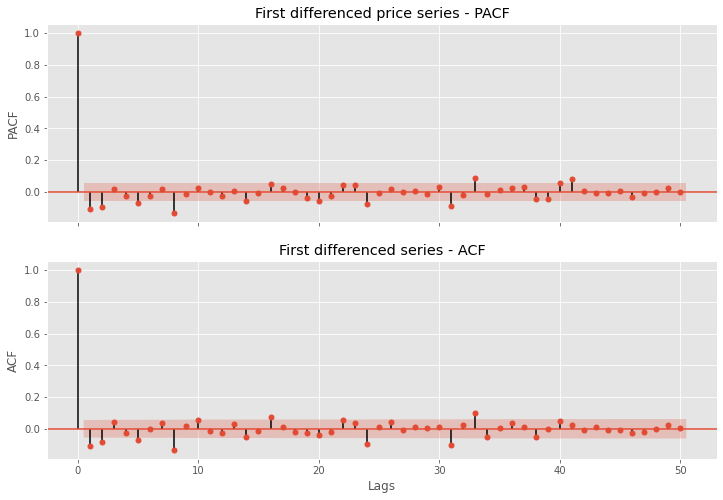

In [135]:
# Plotting both ACF and PACF for First ordered differenced series
fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(12,8),sharex=True)
plot_pacf(train_first_diff,
          lags=50,
          title='First differenced price series - PACF',
          ax=ax0)
plot_acf(train_first_diff, 
         lags=50, 
         title="First differenced series - ACF",
         ax=ax1)
ax0.set(ylabel='PACF')
ax1.set(ylabel='ACF')
ax1.set(xlabel='Lags');



The charts above show that the 33rd and 41st lags are significant lags in the PACF plot, while the 2, 3, 5, 9th lags are significant lags in the ACF plot. While the ADF tests proved that the series is stationary, these values would result in a 33rd ordered ARIMA model, this will be a bit clearer with the formula that is shown below: 
<br>
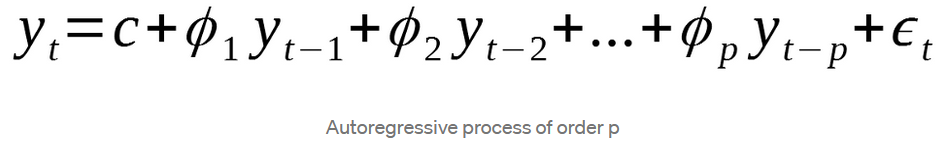
<br>
In AR process, p is the order, c is a constant and epsilon is the noise component.
<br>
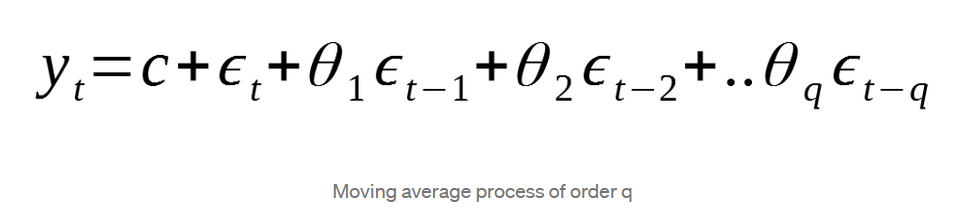
<br>
Similarly, in the MA process, q is the order, c is a constant and epsilon is the noise component.
The higher the order of AR, the higher the complexity of the model, which would make it harder to explain and the forecasted series wouldn't be any different from a random walk. 
<br>
So, we'll continue to try other transformations and use the one that yields us a result that is feasible.

In [136]:
# Log transform 
log_train_diff = np.log(train).diff()

# Differencing - 3day averaged
ma_3d = train.rolling(window=3, center=False).mean() 
diff_ma_3d = ma_3d.diff()
diff_ma_3d_no_nan = diff_ma_3d.dropna()

In [137]:
# Test stationarity 
adf_test_result = adfuller(log_train_diff.dropna())
print('ADF Statistic: %f' % adf_test_result[0])
print('p-value: ' , adf_test_result[1])
for key, value in adf_test_result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -14.906733
p-value:  1.4790565167803659e-27
	1%: -3.436
	5%: -2.864
	10%: -2.568


In [138]:
# Differencing required?
print("Orders of differencing required: ",pmd.ndiffs(diff_ma_3d_no_nan))

Orders of differencing required:  0


In [139]:
adf_test_result = adfuller(diff_ma_3d.dropna())
print('ADF Statistic: ' , adf_test_result[0])
print('p-value: ' , adf_test_result[1])
for key, value in adf_test_result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic:  -7.95836224953722
p-value:  2.994639367842429e-12
	1%: -3.436
	5%: -2.864
	10%: -2.568


In [140]:
# Differencing - 12day exponential average log transformation
ewma_12d_logtrain_diff = np.log(train) - train.ewm(span=3, min_periods=3).mean()
ewma_12d_logtrain_diff_nonan = ewma_12d_logtrain_diff.dropna()

# Exponential log transformation
log_ewma_ = np.log(train).ewm(span=3, min_periods=3).mean()

In [141]:
adf_test_result = adfuller(log_ewma_.dropna())
print('ADF Statistic: ', adf_test_result[0])
print('p-value: ', adf_test_result[1])
for key, value in adf_test_result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic:  -0.4444110705169346
p-value:  0.9024154951328831
	1%: -3.436
	5%: -2.864
	10%: -2.568


In [142]:
adf_test_result = adfuller(ewma_12d_logtrain_diff_nonan)
print('ADF Statistic: ' , adf_test_result[0])
print('p-value: ' , adf_test_result[1])
for key, value in adf_test_result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic:  0.28617670684648183
p-value:  0.976701317255224
	1%: -3.436
	5%: -2.864
	10%: -2.568


In [143]:
# Plot all transformations
fig2 = make_subplots(rows=6, cols=2)

fig2.append_trace(
    go.Scatter(x=full_msft_df.index, 
               y=train,
               mode='lines',
               line=dict(width = 0.75),
               name="Original"),row = 1,col = 1
    )

fig2.append_trace( go.Scatter(x=full_msft_df.index,
                             y=train_first_diff,
                             mode='lines',line=dict(width = 0.75),
               name="Differencing - First ordered "),row = 2,col = 1
)

fig2.append_trace(
    go.Scatter(x=full_msft_df.index, 
               y=diff_ma_3d,
               mode='lines',
               line=dict(width = 0.75),
               name="Differenced 3day-SMA"),row=3,col=1
    )

fig2.append_trace(
    go.Scatter(x=full_msft_df.index, 
               y=ewma_12d_logtrain_diff_nonan,
               mode='lines',
               line=dict(width = 0.75),
               name="Differenced - 12day Exponential"),row=1,col=2
    )

fig2.append_trace(
    go.Scatter(x=full_msft_df.index, 
               y=log_ewma_,
               mode='lines',
               line=dict(width = 0.75),
               name="Log transformation"),row=2,col=2
    )

fig2.append_trace( go.Scatter(x=full_msft_df.index,
                             y=log_train_diff,
                             mode='lines',line=dict(width = 0.75),
               name="Differenced after log transformation"),row = 3,col = 2
)

fig2.update_layout(height=800, width=800, 
                   title_text="Transformations vs Original time-series")

fig2.show()
# Write plot to html file
pio.write_html(fig2, file='img/transformations.html',auto_open=False)

Based on the charts above and the outputs from the Augmented Dickey-Fuller tests for each of the transformations, we can see that for the 3-day averaged differenced series had the best results. The series' ADF test p-value was near zero which and was less than the critical value we had set for the series (0.05). <br>
We can accept that the series is stationary after differencing the series.<br> 
This differenced series can now be used for our ARMA model. 

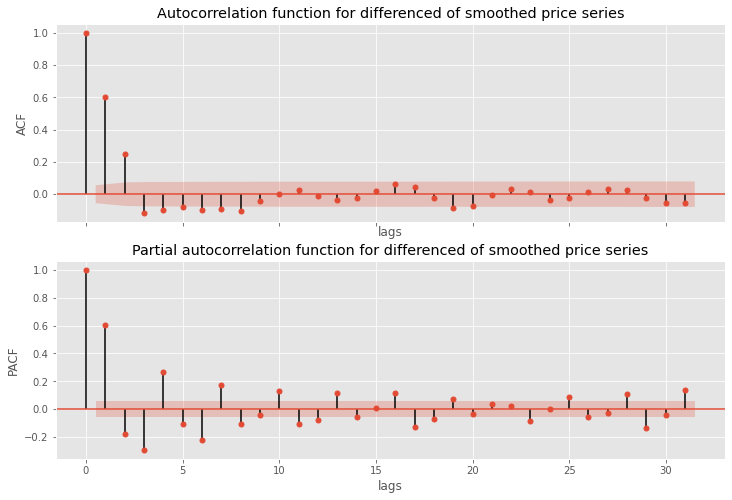

In [144]:
# ma_diff_acf = plot_acf(diff_ma_3d.dropna())
fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(12,8),sharex=True)
plot_acf(diff_ma_3d.dropna(),
         title='Autocorrelation function for differenced of smoothed price series',
         ax=ax0)
plot_pacf(diff_ma_3d.dropna(),
          title='Partial autocorrelation function for differenced of smoothed price series',
          ax=ax1)
ax0.set(xlabel='lags')
ax0.set(ylabel='ACF')
ax1.set(xlabel='lags')
ax1.set(ylabel='PACF');


In a differenced smoothed price series, the ACF plot is displaying significant lags 1 and 2 and PACF has significant lags at various points in the function, but we are more concerned with the significant lags at 2, 3, 5, 6, and 8. These values will be used later to define the AR and MA parameters of the ARIMA model, which subsequently will be used to describe the future price of the stock. 

# Building the ARIMA model 

Auto-Regressive (p) -> Number of autoregressive terms. 
<br>
Integrated (d) -> Number of nonseasonal differences needed for stationarity.
<br>
Moving Average (q) -> Number of lagged forecast errors in the prediction equation.
<br>
In the Auto-ARIMA model, note that small p,d,q values represent non-seasonal components, and capital P, D, Q represent seasonal components. It works similarly like hyperparameter tuning techniques to find the optimal value of p, d, and q with different combinations and the final values would be determined with the lower AIC, BIC parameters taking into consideration.
<br>
Here, we are trying with the p, d, q values ranging from 0 to 5 to get better optimal values from the model.

Source: https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

#### Optimal order for the ARIMA model using auto_arima function


In [145]:
# Find optimal parameters for ARIMA 
order_params_train = auto_arima(train_first_diff,
                                start_p=1,
                                seasonal=False,
                                max_p=3,
                                max_d=3,
                                max_q=5, 
                                information_criterion='aic')
order_params_train.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1255
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -1711.742
Date:                Wed, 19 May 2021   AIC                           3435.484
Time:                        00:47:09   BIC                           3466.294
Sample:                             0   HQIC                          3447.064
                               - 1255                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1344      0.067     -2.003      0.045      -0.266      -0.003
ar.L1         -0.6611      0.025    -26.260      0.000      -0.710      -0.612
ar.L2         -0.9047      0.025    -35.686      0.000      -0.954      -0.855
ma.L1          0.6100      0.032     19.232      0.000       0.548       0.672
ma.L2          0.8368      0.032     25.937      0.000       0.774       0.900
sigma2         0.8957      0.015     58.724      0.000       0.866       0.926
===================================================================================
Ljung-Box (Q):                       83.78   Jarque-Bera (JB):              4581.73
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               5.79   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Rejecting this series because the AIC score is too high. 

In [146]:
order_params_ = auto_arima(diff_ma_3d_no_nan,
                           start_p=1,
                           max_p=3,
                           max_d=3,
                           max_q=5, 
                           information_criterion='aic',
                           scoring_args={'mse'})
order_params_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1254
Model:               SARIMAX(3, 0, 1)   Log Likelihood                -508.952
Date:                Wed, 19 May 2021   AIC                           1029.904
Time:                        00:47:14   BIC                           1060.709
Sample:                             0   HQIC                          1041.483
                               - 1254                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0417      0.015      2.737      0.006       0.012       0.072
ar.L1          0.2908      0.038      7.684      0.000       0.217       0.365
ar.L2          0.3129      0.026     12.158      0.000       0.262       0.363
ar.L3         -0.4016      0.017    -23.926      0.000      -0.434      -0.369
ma.L1          0.4145      0.039     10.701      0.000       0.339       0.490
sigma2         0.1317      0.002     53.638      0.000       0.127       0.137
===================================================================================
Ljung-Box (Q):                      211.19   Jarque-Bera (JB):              3300.63
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               5.23   Skew:                            -0.68
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

After testing the parameters on the model in the cells below, it was found that the order of (3,0,2) had the lowest AIC score and was therefore chosen as the order for the price forecasts going forward.
<br>
**Important note:** Generally, when choosing the optimal order for ARIMA models, we select the model with the lowest AIC, more parameters will increase the AIC score and thus penalize the model. A small AIC value does not a guarantee that the model will have a good performance on unseen data, or that its squared estimate of errors(SSE) will be small. 
<br>
Source: https://towardsdatascience.com/advanced-time-series-analysis-with-arma-and-arima-a7d9b589ed6d

In [147]:
# ARIMA for 3-day moving average differenced time series
ma3_arima_model = ARIMA(endog=diff_ma_3d_no_nan, order=(3,0,2))

# Fit the differenced series
ma3_model_res = ma3_arima_model.fit()

# Display results of model
print(ma3_model_res.summary())

C:\Users\TerenceY\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\TerenceY\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\TerenceY\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                               SARIMAX Results                                
Dep. Variable:              Adj_Close   No. Observations:                 1254
Model:                 ARIMA(3, 0, 2)   Log Likelihood                -343.921
Date:                Wed, 19 May 2021   AIC                            701.841
Time:                        00:47:15   BIC                            737.780
Sample:                             0   HQIC                           715.350
                               - 1254                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0531      0.024      2.184      0.029       0.005       0.101
ar.L1         -0.1149      0.015     -7.623      0.000      -0.144      -0.085
ar.L2         -0.0951      0.016     -5.881      0.0

C:\Users\TerenceY\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



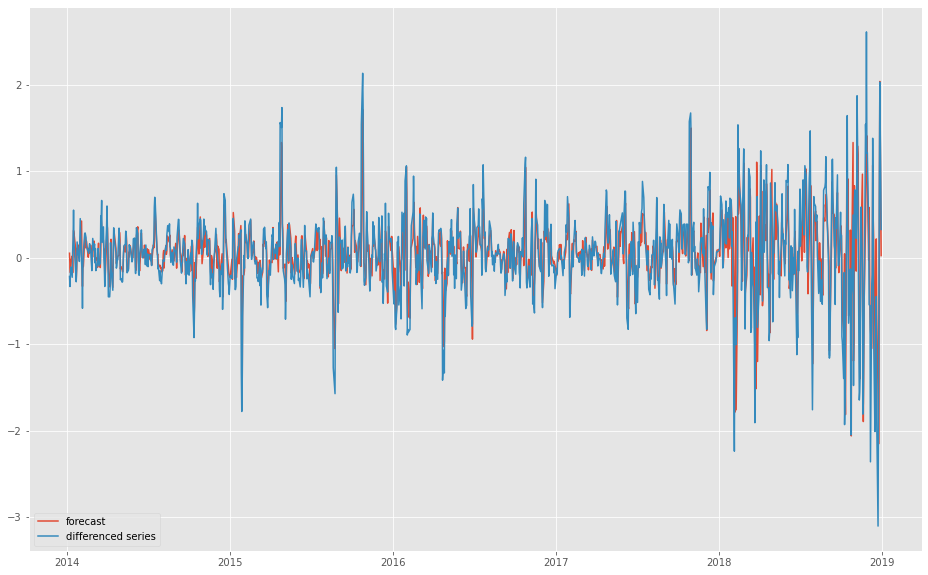

In [148]:
# Forecasting based on moving average 
y_hat = ma3_model_res.predict()
y_hat.index = pd.to_datetime(y_hat.index,format='%Y-%m-%d')
_ = plt.plot(y_hat)
_ = plt.plot(diff_ma_3d)
plt.legend(['forecast','differenced series'],loc='lower left')
plt.show() 

In order to see how accurately forecasts the price of the stock, we will need to invert the transformations that we had performed on the series (diff_ma_3d) prior fitting the model. 

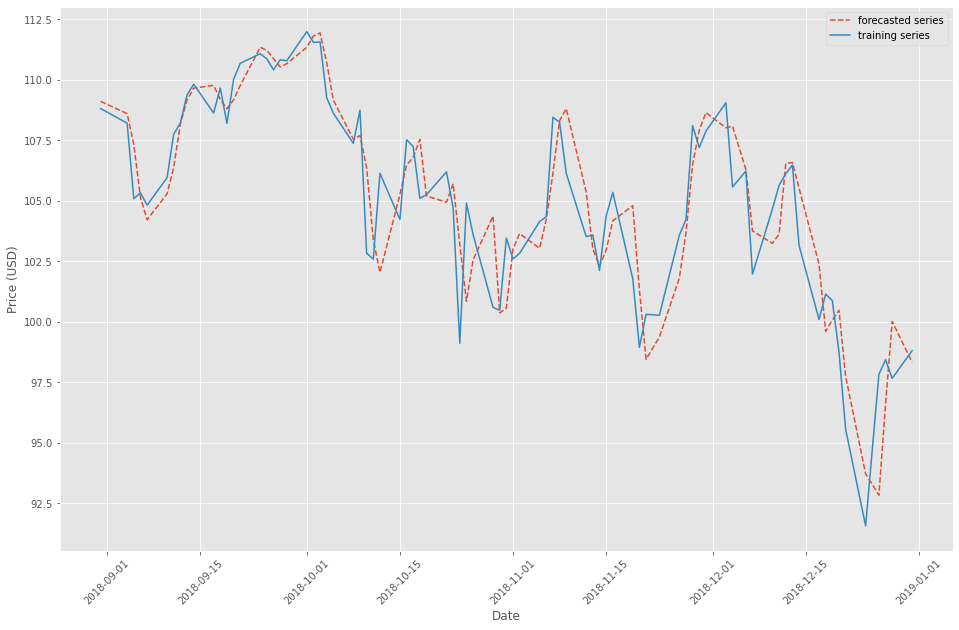

In [149]:
forecasted_train = y_hat + ma_3d 
forecasted_train.index = pd.to_datetime(forecasted_train.index)
_ = plt.plot(forecasted_train['2018-08-31':], ls='--')
_ = plt.plot(train['2018-08-31':])
_ = plt.ylabel('Price (USD)')
_ = plt.xlabel('Date')
_ = plt.xticks(rotation='45')
_ = plt.legend(['forecasted series','training series'],loc='best')
plt.show()

What we want to do now is : 
1. Apply model on test series via moving windows using current p,d,q. Add test data 1 day at a time.  Or use the predicted values instead for a quarter of the year (90 days)
2. Validate this model using RMSE, MSE


In [150]:
warnings.filterwarnings("ignore")

# Loop that predicts one day at a time and retrains on new data point.  
for i in range(30):
    ma_3d = forecasted_train.rolling(window=3, center=False).mean() 
    diff_ma_3d = ma_3d.diff()
    diff_ma_3d_no_nan = diff_ma_3d.dropna()
    ma3_model = ARIMA(endog=diff_ma_3d_no_nan, order=(3,0,2))
    new_model_res = ma3_model.fit()
    raw_forecasted_train = new_model_res.predict(start=len(diff_ma_3d_no_nan),
                                      end=len(diff_ma_3d_no_nan)+1)
    to_append = pd.Series(dict(zip(test.index,(raw_forecasted_train))),dtype='object')
    to_append[0]+= forecasted_train[-1]
    to_append[1]+= to_append[0]
    forecasted_train = forecasted_train.append(to_append)


In [151]:
# Replace index in forecasted series
future_prices_ = forecasted_train['2019-01-02':]
future_prices_.index = test.index[:len(future_prices_)]
# future_prices_.index

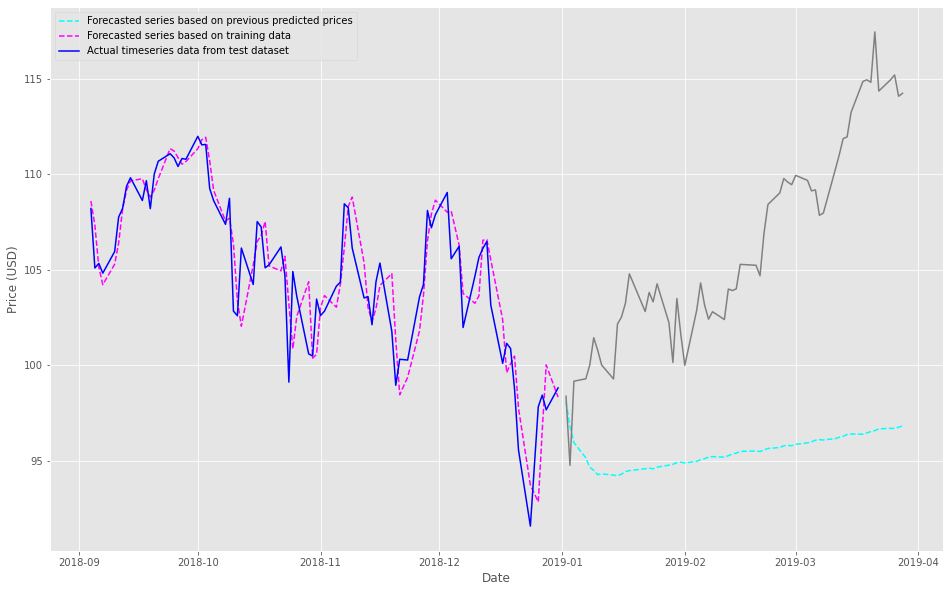

In [152]:
# Comparison of series 
_ = plt.plot(future_prices_, c='cyan',ls='--')
_ = plt.plot(forecasted_train['2018-09-01':'2018-12-31'],c='magenta',ls='--')
_ = plt.plot(train['2018-09-01':'2018-12-31'],c='blue')
_ = plt.plot(test[:len(future_prices_)],c='gray')
_ = plt.xlabel('Date')
_ = plt.ylabel('Price (USD)')
_ = plt.legend(['Forecasted series based on previous predicted prices', 
                'Forecasted series based on training data', 
                'Actual timeseries data from test dataset' ])
plt.show()

#### Model Performance 

In [153]:
mean_sq_err = mean_squared_error(future_prices_, test[:len(future_prices_)])
print("mean squared error with respect to test : ", mean_sq_err)

mean squared error with respect to test :  137.2345675417849


Let's try something different. What if we plug in the real world data per diem and see how that changes the accuracy of the forecasting. 

In [154]:
# Add end of day close price (test) instead of predicted price
train_copy = train
predicted_val_list = []
for i in range(25):
    ma_3d = train_copy.rolling(window=3, center=False).mean() 
    diff_ma_3d = ma_3d.diff()
    diff_ma_3d_no_nan = diff_ma_3d.dropna()
    ma3_model = ARIMA(endog=diff_ma_3d_no_nan, order=(3,0,2))
    new_model_res = ma3_model.fit()
    raw_predict = new_model_res.predict(end=len(train_copy)+1)
    forecasted_val = raw_predict.iloc[-1]+train_copy.iloc[-1]
    predicted_val_list.append(forecasted_val)
    train_copy = train_copy.append(pd.Series(test[i]))


In [155]:
index_ = pd.to_datetime(test.index,format='%Y-%m-%d')
predicted_series = pd.Series(predicted_val_list,index=index_[:len(predicted_val_list)])

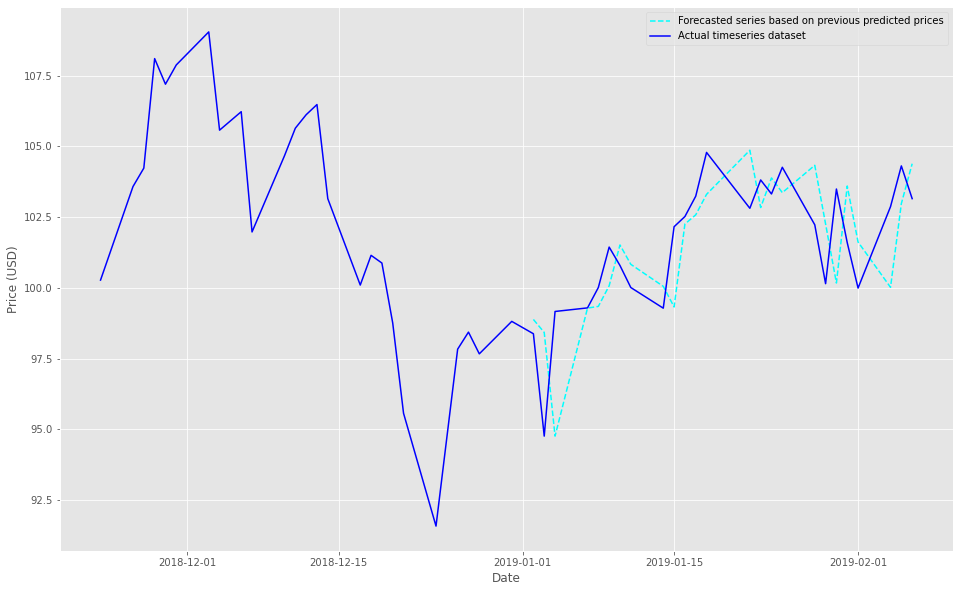

In [156]:
_ = plt.plot(predicted_series, c='cyan',ls='--')
_ = plt.plot(full_msft_df['Adj_Close'][len(train)-25:len(train)+25],c='blue')
_ = plt.xlabel('Date')
_ = plt.ylabel('Price (USD)')
_ = plt.legend(['Forecasted series based on previous predicted prices', 
                'Actual timeseries dataset' ])
plt.show()

In [157]:
mean_sq_err = mean_squared_error(predicted_series, test[:len(predicted_series)])
print("mean squared error with respect to test : ", mean_sq_err)

mean squared error with respect to test :  3.691286865400158


Sample code for K-means is listed below that should be tried out if we decide to go with unsupervised clustering

In [ ]:
# Import the necessary packages
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
# Define a normalizer
normalizer = Normalizer()

# Create Kmeans model
kmeans = KMeans(n_clusters = 10,max_iter = 1000)

# Make a pipeline chaining normalizer and kmeans
pipeline = make_pipeline(normalizer,kmeans)

# Fit pipeline to daily stock movements
pipeline.fit(full_msft_df[:'2019-01-02'].dropna())

labels = pipeline.predict(full_msft_df['2019-01-02':].dropna())

from sklearn.decomposition import PCA 

# Reduce the data
reduced_data = PCA(n_components = 2).fit_transform(labels.reshape(-1, 1))

# Define step size of mesh
h = 0.01

# Plot the decision boundary
x_min,x_max = reduced_data[:,0].min()-1, reduced_data[:,0].max() + 1
y_min,y_max = reduced_data[:,1].min()-1, reduced_data[:,1].max() + 1
xx,yy = np.meshgrid(np.arange(x_min,x_max,h),np.arange(y_min,y_max,h))

# Obtain labels for each point in the mesh using our trained model
Z = kmeans.predict(np.c_[xx.ravel(),yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

# Define color plot
cmap = plt.cm.Paired

# Plotting figure
plt.clf()
plt.figure(figsize=(10,10))
plt.imshow(Z,interpolation = 'nearest',extent=(xx.min(),xx.max(),
                                               yy.min(),yy.max()
                                              ), cmap = cmap, aspect = 'auto',origin = 'lower')

plt.plot(reduced_data[:,0],reduced_data[:,1],'k.',markersize = 5)

# Plot the centroid of each cluster as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:,0],
            centroids[:,1],
            marker = 'x',s = 169,
            linewidths = 3,color = 'w',
            zorder = 10)
plt.title('K-Means clustering on stock market movements (PCA-Reduced data)')
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)
plt.show()

The cluster formation with PCA reduction is different from the cluster formation without PCA reduction. The cons of PCA reduction is some details are lost. The results are not very accurate. The pros of PCA reduction is less computational power and easy visualization.